# From Sentiments to Strategies: Building an NLP Model for Brand Engagement

`
from IPython.display import Image
`
Image(url = "https://storage.ning.com/topology/rest/1.0/file/get/3780584426?profile=original",width = 1000, height=800)


# Data understanding

The dataset was sourced from data.world provided by CrowdFlower which has tweets about Apple and Google from the South by Southwest (SXSW) conference. The tweet labels were crowdsourced and reflect which emotion they convey and what product/service/company this emotion is directed at based on the content.

There are 9093 records and 3 features in this data.

Associated columns in the dataset are:
- `tweet_text`: Contains the text of the tweets.

- `emotion_in_tweet_is_directed_at`: Indicates the brand or product mentioned in the tweet (many missing values).

- `is_there_an_emotion_directed_at_a_brand_or_product`: Categorizes the sentiment as "Positive emotion," "Negative emotion," or potentially other classes.

The column names will be renamed to manageable ones in the data cleaning steps

# Data Preparation

In [124]:
# Data Exploration Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# Preprocessing and Feature Extraction
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Handling Imbalanced Data
from imblearn.over_sampling import SMOTE

# Model Selection and Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier 


In [125]:
# Ensure necessary NLTK resources are downloaded
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Overview

In [126]:
class DataOverview():
    """
    This class takes a dataframe and returns basic information.
    """
    def __init__(self, data):
        self.data = data

    def read_head(self):
        """Returns the first 5 rows"""
        return self.data.head()

    def read_columns(self):
        """Returns the columns of the DataFrame"""
        return self.data.columns

    def read_info(self):
        """Returns the features, datatypes and non-null count"""
        return self.data.info()
    def read_describe(self):
        """Returns the statistical summary of the dataset"""
        return self.data.describe()
    def read_shape(self):
        """Returns the number of rows and columns"""
        return self.data.shape
    def read_unique(self,column_name):
        """Returns unique values for a specific column"""
        if column_name in self.data.columns:
            return self.data[column_name].unique()
        else:
            raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    def read_corr(self):
        """Returns a correlation dataframe"""
        return self.data.corr()

    def read_corr_wrt_target(self, target='churn'):
        """Returns a Series containing the correlation of features with respect to target"""
        return self.data.corr()[target].sort_values(ascending=False)

    def read_multicollinearity(self, target='churn'):
        """Returns a correlation dataframe without the target"""
        return self.data.corr().iloc[0:-1, 0:-1]

    def read_na(self):
        """Returns the sum of all null values per feature"""
        return self.data.isna().sum()

    def read_duplicated(self):
        """Returns the sum of all duplicated records"""
        return self.data.duplicated().sum()

In [127]:
# The data
filepath='../data/tweet_product_company.csv'
df = pd.read_csv(filepath,encoding='iso-8859-1')

In [128]:
# Instantiate datapreparation object
dprep = DataOverview(data=df)

# First 5 lines of the DataFrame
dprep.read_head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,".@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead! I need to upgrade. Plugin stations at #SXSW.",iPhone,Negative emotion
1,"@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw,iPad or iPhone App,Negative emotion
4,"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",Google,Positive emotion


Renaming the column names for easier work and readability as they are very long

In [129]:
# Renaming columns for ease of work
df.rename(columns = {'tweet_text': 'Text', 'emotion_in_tweet_is_directed_at': 'Product/Brand', 
                     'is_there_an_emotion_directed_at_a_brand_or_product':'Emotion'}, inplace = True)


Exploring features and their datatypes

In [130]:
dprep.read_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Emotion        9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [131]:
# Exploring feature null values
dprep.read_na()

Text                1
Product/Brand    5802
Emotion             0
dtype: int64

Product has 5802 nulls values i.e 64% of all records in the dataset, while Text has 1 missing records

We take a look at the Product/Brand and Emotion columns to check their unique values.

In [132]:
dprep.read_unique('Product/Brand')

array(['iPhone', 'iPad or iPhone App', 'iPad', 'Google', nan, 'Android',
       'Apple', 'Android App', 'Other Google product or service',
       'Other Apple product or service'], dtype=object)

In [133]:
dprep.read_unique('Emotion')

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

- Product/Brand: We observe a lof of information on different products and services for the different brands.There is also nan values.
- Emotion: We observe 'I can't tell' emotion which is ambigous, and thus will need handling

# Data Cleaning

## Addressing Missing Values

Remember we were missing the body of text for 1 tweet and a total of 5,802 tags for which product/brand the corresponding tweet was about. Let's start with looking at the missing tweet.

In [134]:
# create a copy for cleaning purposes
df_1 = df.copy()

In [135]:
df_1[df_1['Text'].isna()]

,Text,Product/Brand,Emotion
6,NaN,NaN,No emotion toward brand or product


Valuable information(customer sentiment) is missing from this Text, thus worthless, we can drop the record. 

In [136]:
df_1 = df_1[df_1['Text'].notna()]
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           9092 non-null   object
 1   Product/Brand  3291 non-null   object
 2   Emotion        9092 non-null   object
dtypes: object(3)
memory usage: 284.1+ KB


Next, we look at Product/Brand missing values which has a total of 5801 missing tags

In [137]:
df_1[df_1['Product/Brand'].isna()].head(10)

,Text,Product/Brand,Emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store - http://t.co/kfN3f5Q (via @marc_is_ken) #sxsw,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register for #GDGTLive and see Cobra iRadar for Android. {link}",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
34,Anyone at #SXSW who bought the new iPad want to sell their older iPad to me?,NaN,No emotion toward brand or product
35,"At #sxsw. Oooh. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link}",NaN,No emotion toward brand or product
37,SPIN Play - a new concept in music discovery for your iPad from @mention &amp; spin.com {link} #iTunes #sxsw @mention,NaN,No emotion toward brand or product
39,VatorNews - Google And Apple Force Print Media to Evolve? {link} #sxsw,NaN,No emotion toward brand or product
41,"HootSuite - HootSuite Mobile for #SXSW ~ Updates for iPhone, BlackBerry &amp; Android: Whether youÛªre getting friend... {link}",NaN,No emotion toward brand or product
42,Hey #SXSW - How long do you think it takes us to make an iPhone case? answer @mention using #zazzlesxsw and weÛªll make you one!,NaN,No emotion toward brand or product


Observation is that the tweets are not directed to any specific brand or product, we will thus use 'Unknown' as a placeholder

In [138]:
df_1['Product/Brand'].fillna('Unknown', inplace = True)

In [139]:
# Verifying the null values are handled
df_1.isna().sum()

Text             0
Product/Brand    0
Emotion          0
dtype: int64

## Handling the Emotion Column

In [140]:
df_1['Emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: Emotion, dtype: int64

For easy interpretability the emotion values can be cleaned to shorter formats

In [141]:
df_1['Emotion'] = df_1['Emotion'].replace({
    'Positive emotion': 'Positive',
    'Negative emotion': 'Negative',
    'No emotion toward brand or product': 'Neutral',
    "I can't tell": 'Unknown'
})

In [142]:
# verifying emotion values
df_1['Emotion'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Unknown      156
Name: Emotion, dtype: int64

We take a look at the tweets with 'Unknown' emotion values to check wether we can identify any patterns or we can easily tell/categorise them in the Neutral,Positive or Negative categories

In [143]:
pd.set_option("display.max_colwidth", 300)
df_1[df_1['Emotion']=='Unknown']

,Text,Product/Brand,Emotion
90,Thanks to @mention for publishing the news of @mention new medical Apps at the #sxswi conf. blog {link} #sxsw #sxswh,Unknown,Unknown
102,ÛÏ@mention &quot;Apple has opened a pop-up store in Austin so the nerds in town for #SXSW can get their new iPads. {link} #wow,Unknown,Unknown
237,"Just what America needs. RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown,Unknown
341,The queue at the Apple Store in Austin is FOUR blocks long. Crazy stuff! #sxsw,Unknown,Unknown
368,Hope it's better than wave RT @mention Buzz is: Google's previewing a social networking platform at #SXSW: {link},Unknown,Unknown
...,...,...,...
9020,It's funny watching a room full of people hold their iPad in the air to take a photo. Like a room full of tablets staring you down. #SXSW,Unknown,Unknown
9032,"@mention yeah, we have @mention , Google has nothing on us :) #SXSW",Unknown,Unknown
9037,"@mention Yes, the Google presentation was not exactly what I was expecting. #sxsw",Unknown,Unknown
9058,&quot;Do you know what Apple is really good at? Making you feel bad about your Xmas present!&quot; - Seth Meyers on iPad2 #sxsw #doyoureallyneedthat?,Unknown,Unknown


From observation, this tweets are difficult to classify without further context. Some might be genuine and some sarcastic and thus may not be useful for our models as we need to have labels. The solution is to drop them, as they also are only 
1.7% of the dataset.

In [144]:
# dropping the 'Unknown' in the Emotion column
df_1 = df_1.loc[df_1['Emotion'] != 'Unknown']
# Verifying they are dropped
df_1['Emotion'].value_counts()

Neutral     5388
Positive    2978
Negative     570
Name: Emotion, dtype: int64

# Handling Duplicates

As we've addressed null values, and cleaned up our dataset a little bit more, next step is to check for duplicates (check tweets repeated multiple times).

In [145]:
df_1.duplicated().sum()

22

We have 22 tweets that are duplicated. Lets have a closer look 

In [146]:
df_1[df_1.duplicated()]

,Text,Product/Brand,Emotion
468,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive
776,"Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown,Neutral
2232,Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw,Unknown,Neutral
2559,Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear,Apple,Positive
3950,Really enjoying the changes in Gowalla 3.0 for Android! Looking forward to seeing what else they &amp; Foursquare have up their sleeves at #SXSW,Android App,Positive
3962,"#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan",Android,Positive
4897,"Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!",iPad or iPhone App,Positive
5338,RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter,Unknown,Neutral
5341,"RT @mention ÷¼ Happy Woman's Day! Make love, not fuss! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter",Unknown,Neutral
5881,"RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw",Unknown,Neutral


In [147]:
df_1.drop_duplicates(keep='first', inplace=True)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8914 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Text           8914 non-null   object
 1   Product/Brand  8914 non-null   object
 2   Emotion        8914 non-null   object
dtypes: object(3)
memory usage: 278.6+ KB


Next we move on to EDA as we have already done the data cleaning process

# Exploratory Data Analysis

Referring to our business problem , we will isolate and analyze positive and negative tweets as a whole as well as on a company and product basis. However, before conducting any EDA on sentiments we need to tokenize,lematize and remove stop words.

We start by creating a function to perform tokenization, lemmatization and stop words. For tokenizer we will apply tweet tokenizer, because we are dealing with social media data, as it can handle special social media tokens such as @ , #, emojis etc. 

### Tokenization, Lemmatization and Stopwords Removal

In [148]:
# Stopword list with additional punctuation
stop_lst = stopwords.words('english') + list(string.punctuation)
stop_lst += ['“', '”', '...', "''", '’', '``', '']

def tokenize_lemmatize_remove_stopwords(corpus, preserve_case=False, strip_handles=True, 
                                        stop_list=None, additional_stopwords=None):
    """
    Tokenizes, lemmatizes, and removes stopwords from a given corpus.
    
    Args:
    - corpus: List of text to process.
    - preserve_case: Whether to keep upper case letters as upper case.
    - strip_handles: Whether to remove Twitter handles.
    - stop_list: Base list of stopwords (default to NLTK stop words + punctuation).
    - additional_stopwords: Optional additional words to exclude from the tokens.
    
    Returns:
    - List of clean lemmatized tokens without stopwords.
    """
    # Initialize tokenizer and lemmatizer
    tokenizer = TweetTokenizer(preserve_case=preserve_case, strip_handles=strip_handles)
    lemmatizer = WordNetLemmatizer()
    
    # Use the provided stop list or default to stop_lst
    if stop_list is None:
        stop_list = stop_lst

    # Extend stop list with additional custom stopwords
    if additional_stopwords:
        stop_list = stop_list + additional_stopwords

    # Tokenize corpus
    tokens = tokenizer.tokenize(','.join(corpus))
    
    # Lemmatize and remove stopwords
    tokens_cleaned = [lemmatizer.lemmatize(token).encode('ascii', 'ignore').decode() 
                       for token in tokens 
                       if token not in stop_list and not token.startswith('http')]
    
    return tokens_cleaned


Now lets start by exploring positive sentiments

## Tweets with positive sentiments

In [149]:
#parsing positive tweets into new df
df_positive = df_1[df_1['Emotion']=='Positive']
#verifying that neutral and negative tweets have been removed
df_positive['Emotion'].value_counts()

Positive    2970
Name: Emotion, dtype: int64

In [150]:
#parsing positive tweets into a list
corpus_pos = df_positive['Text'].to_list()
corpus_pos[:7]

["@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)",
 '#SXSW is just starting, #CTIA is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan',
 'Beautifully smart and simple idea RT @madebymany @thenextweb wrote about our #hollergram iPad app for #sxsw! http://bit.ly/ieaVOB',
 'Counting down the days to #sxsw plus strong Canadian dollar means stock up on Apple gear',
 'Excited to meet the @samsungmobileus at #sxsw so I can show them my Sprint Galaxy S still running Android 2.1.   #fail']

Applying the function `tokenize_lemmatize_remove_stopwords`

In [151]:
tokens_pos_cleaned = tokenize_lemmatize_remove_stopwords(corpus_pos)

Defining a function to display most frequent 50 values 

In [152]:
from nltk import FreqDist
def find_frequent(tokens, n=50):
    """Function returns the n most common words along with their frequencies 
    based on a tokens list passed in.
    -------------------------------
    Arguments:
    tokens: a tokens list
    n: number of top words to be returned"""
    
    freq = FreqDist(tokens)
    display(freq.most_common(n))

In [153]:
#displaying 50 most frequent words
find_frequent(tokens_pos_cleaned)

[('#sxsw', 2983),
 ('link', 1218),
 ('ipad', 1010),
 ('rt', 931),
 ('apple', 711),
 ('google', 602),
 ('2', 595),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('sxsw', 144),
 ('line', 143),
 ('time', 136),
 ('great', 135),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('free', 120),
 ('cool', 119),
 ("i'm", 115),
 ('like', 115),
 ('map', 115),
 ('one', 114),
 ('win', 112),
 ('today', 111),
 ('circle', 107),
 ('w', 104),
 ('go', 104),
 ('come', 103),
 ('#sxswi', 96),
 ('awesome', 93),
 ('#ipad', 93),
 ('love', 93),
 ('good', 92),
 ('network', 91),
 ('mobile', 90),
 ('temporary', 89),
 ('downtown', 88),
 ('opening', 88),
 ('people', 82)]

The list of 50 common words still contains some words that aren't useful for sentiment analysis, like '#sxsw', which can be removed. Words such as 'link' and 'rt' often refer to external links or retweets, though 'link' might have a different meaning. A function can help by selecting random tweets, checking for a specific word, and displaying the relevant tweets.

Creating a function that will help identify context for any given word

In [154]:
def context_finder(word, corpus, n_samples=5, n_count=5):
    """
    Displays tweets containing a specific word from random samples in the corpus.
    
    Args:
    - word: the target word to search for.
    - corpus: list of tweets or text.
    - n_samples: number of random samples to check.
    - n_count: number of tweets per sample.
    """
    matched_tweets = []
    
    # Collect matching tweets from random samples
    for _ in range(n_samples):
        sample = np.random.choice(corpus, n_count)
        matched_tweets.extend([tweet for tweet in sample if word in tweet])
    
    # Display results
    for tweet in matched_tweets:
        print(tweet)
        
    print('-----------------------------------')
    print(f'Out of {n_samples * n_count} tweets analyzed, {len(matched_tweets)} contained the word "{word}".')


In [155]:
#verifying that 'link' is used in reference to external web links
context_finder('link', corpus_pos)

One of my fav photos of #SXSW so far @mention &amp;  @mention #google #SXSW {link}
RT @mention Excited to see this! RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
Tech Check podcast -- #SxSW #Android passes #BlackBerry, a big Twitter #fail! -- {link} by @mention #sxsw #cnn
@mention iPhone app is leading the pack, but android (blue) users #s are growing #sxswmobileapps #sxsw {link}
One of the best photo apps for the iPhone ÛÓ Hipstamatic ÛÓ is getting ...  #apps #sxsw #hipstamatic {link}
Does your #SmallBiz need reviews to play on Google Places...We got an App for that..{link}  #seo #sxsw
@mention apple's making a temp store for #SXSW 2011 for u to get an iPad 2 !! {link}
Check in and offers through Google, cool. {link} #SXSW
Already had my first Google Circle search result. {link} cc @mention @mention #sxsw
Google party! #sxsw (@mention GSD&amp;M w/ 157 others) {link}
We really DO need another big social network right now - thanks! #

Observation is that 'link' is used to refer to weblinks that were removed when data was being passed to dataset. We will thus add it to the stop list

We take a deeper dive on 'RT' to provide its context

In [156]:
context_finder('RT', corpus_pos)

RT @mention Heat Tracker is a cool heatmap iPhone app overlay for Foursquare, but everything is on fire here #SXSW
RT @mention Google is focusing on bridging the digital/physical divide. Eg. maps, streetview, hotpot &amp; autonomous driving. #sxsw @mention
Love it . RT @mention From #Apple to Naomi Campbell: pop-up stores are all the rage: {link} #sxsw
RT @mention YES! updated iPhone app has song info @mention 24/7 stream +others also live video streaming for #SXSW {link}
RT RT @mention The iPad 2 Takes Over #SXSW [VIDEO] {link} RT @mention The iP... {link} #Vegas #News
RT @mention We lose an hour tonight. #SxSW attendees will blame Microsoft, Apple will get credit for fixing it before Christmas.
Such suspense! RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw
RT @mention Love it. @mention #sxsw: &quot;apple comes up with cool technology no one's ever heard of because they don't go to conferences&quot;
-----------------------------------


We observed that in all cases 'RT' or 'rt' is used to denote a retweet, therefore we can also add it to the stop list

In [157]:
# Adding all additional words from findings to stop list

extra_words = ['#sxsw', '#sxswi', 'sxsw','link','rt']

Processing the corpus with additional words (extra words)

In [158]:
tokens_pos_cleaned = tokenize_lemmatize_remove_stopwords(corpus_pos,additional_stopwords=extra_words)

In [159]:
#displaying 50 most frequent words
find_frequent(tokens_pos_cleaned)

[('ipad', 1010),
 ('apple', 711),
 ('google', 602),
 ('2', 595),
 ('store', 554),
 ('iphone', 466),
 ('', 443),
 ('app', 387),
 ('new', 358),
 ('austin', 250),
 ('get', 181),
 ('#apple', 174),
 ('launch', 173),
 ('android', 161),
 ('party', 151),
 ('pop-up', 151),
 ('line', 143),
 ('time', 136),
 ('great', 135),
 ('via', 132),
 ('#ipad2', 129),
 ('day', 124),
 ('social', 122),
 ('free', 120),
 ('cool', 119),
 ("i'm", 115),
 ('like', 115),
 ('map', 115),
 ('one', 114),
 ('win', 112),
 ('today', 111),
 ('circle', 107),
 ('w', 104),
 ('go', 104),
 ('come', 103),
 ('awesome', 93),
 ('#ipad', 93),
 ('love', 93),
 ('good', 92),
 ('network', 91),
 ('mobile', 90),
 ('temporary', 89),
 ('downtown', 88),
 ('opening', 88),
 ('people', 82),
 ('open', 82),
 ('#iphone', 82),
 ('got', 81),
 ('apps', 78),
 ('check', 77)]

We observe that the most common words include 'apple' and 'google', but there are additional words such as 'circle', 'launch' and 'store' in here that show us what the people were excited about. However, we are only looking at 50 words and there may be additional information here that we are missing. To address this, we can visualize this information in word clouds.

## Tweets with Negative Sentiments

In [160]:
#parsing positive tweets into new df
df_negative = df_1[df_1['Emotion']=='Negative']
#verifying that neutral and negative tweets have been removed
df_negative['Emotion'].value_counts()

Negative    569
Name: Emotion, dtype: int64

In [161]:
#parsing tweets into a list
corpus_neg = df_negative['Text'].to_list()
corpus_neg[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 'I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone',
 '@mention  - False Alarm: Google Circles Not Coming Now\x89ÛÒand Probably Not Ever? - {link} #Google #Circles #Social #SXSW',
 'Again? RT @mention Line at the Apple store is insane.. #sxsw']

Applying the function `tokenize_lemmatize_remove_stopwords`

In [162]:
tokens_neg_cleaned = tokenize_lemmatize_remove_stopwords(corpus_neg,additional_stopwords=extra_words)

In [163]:
#displaying 50 most frequent words
find_frequent(tokens_neg_cleaned)

[('ipad', 179),
 ('iphone', 145),
 ('google', 136),
 ('apple', 100),
 ('2', 81),
 ('', 69),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('circle', 29),
 ('design', 29),
 ('people', 29),
 ('social', 28),
 ('apps', 26),
 ('get', 25),
 ('austin', 23),
 ('think', 23),
 ('time', 23),
 ('launch', 22),
 ('one', 22),
 ('day', 21),
 ('today', 21),
 ('look', 21),
 ('line', 20),
 ('say', 20),
 ('android', 19),
 ('#ipad', 19),
 ('would', 19),
 ('network', 18),
 ('phone', 18),
 ('headache', 17),
 ('news', 17),
 ('go', 17),
 ('long', 17),
 ('product', 17),
 ("i've", 16),
 ("i'm", 16),
 ('battery', 16),
 ('user', 15),
 ('thing', 15),
 ('#apple', 15),
 ('good', 15),
 ('see', 15),
 ('much', 15),
 ('company', 15),
 ('america', 15),
 ('money', 14),
 ('major', 14)]

Once again, we see that Apple and Google are mentioned quite a few times in the negative tweets along with words such as 'design' and 'launch'. We can visualize and try to dig deeper.

## Visualization Positive Vs Negative Sentiments

In [164]:
# Library to visualize sentiments
from wordcloud import WordCloud

In [165]:
def generate_wordcloud(tokens1, tokens2=None, collocations=False, background_color='black', 
                       colormap1='Greens', colormap2='Reds'):
    """
    Function generates and displays one or two word clouds side by side.
    
    Arguments:
    tokens1: List of tokens for the first word cloud.
    tokens2: (Optional) List of tokens for the second word cloud for comparison.
    collocations: Whether to include collocations (bigrams) of two words.
    background_color: Background color of the word clouds.
    colormap1: Color map for the first word cloud.
    colormap2: Color map for the second word cloud (if tokens2 is provided).
    """
    fig, axes = plt.subplots(1, 2 if tokens2 else 1, figsize=(30, 20))

    # Ensure axes is iterable when there's only one plot
    if tokens2 is None:
        axes = [axes]

    # Generate and plot the first word cloud
    wordcloud1 = WordCloud(collocations=collocations, background_color=background_color,
                            colormap=colormap1, width=500, height=300)
    wordcloud1.generate(','.join(tokens1))
    axes[0].imshow(wordcloud1)
    axes[0].axis('off')
    axes[0].set_title("Dataset 1 Word Cloud")

    # Generate and plot the second word cloud if tokens2 is provided
    if tokens2:
        wordcloud2 = WordCloud(collocations=collocations, background_color=background_color,
                                colormap=colormap2, width=500, height=300)
        wordcloud2.generate(','.join(tokens2))
        axes[1].imshow(wordcloud2)
        axes[1].axis('off')
        axes[1].set_title("Dataset 2 Word Cloud")

    plt.tight_layout()
    plt.show()


### With Product/Brand information

We generate a word cloud with product and company(brand) information

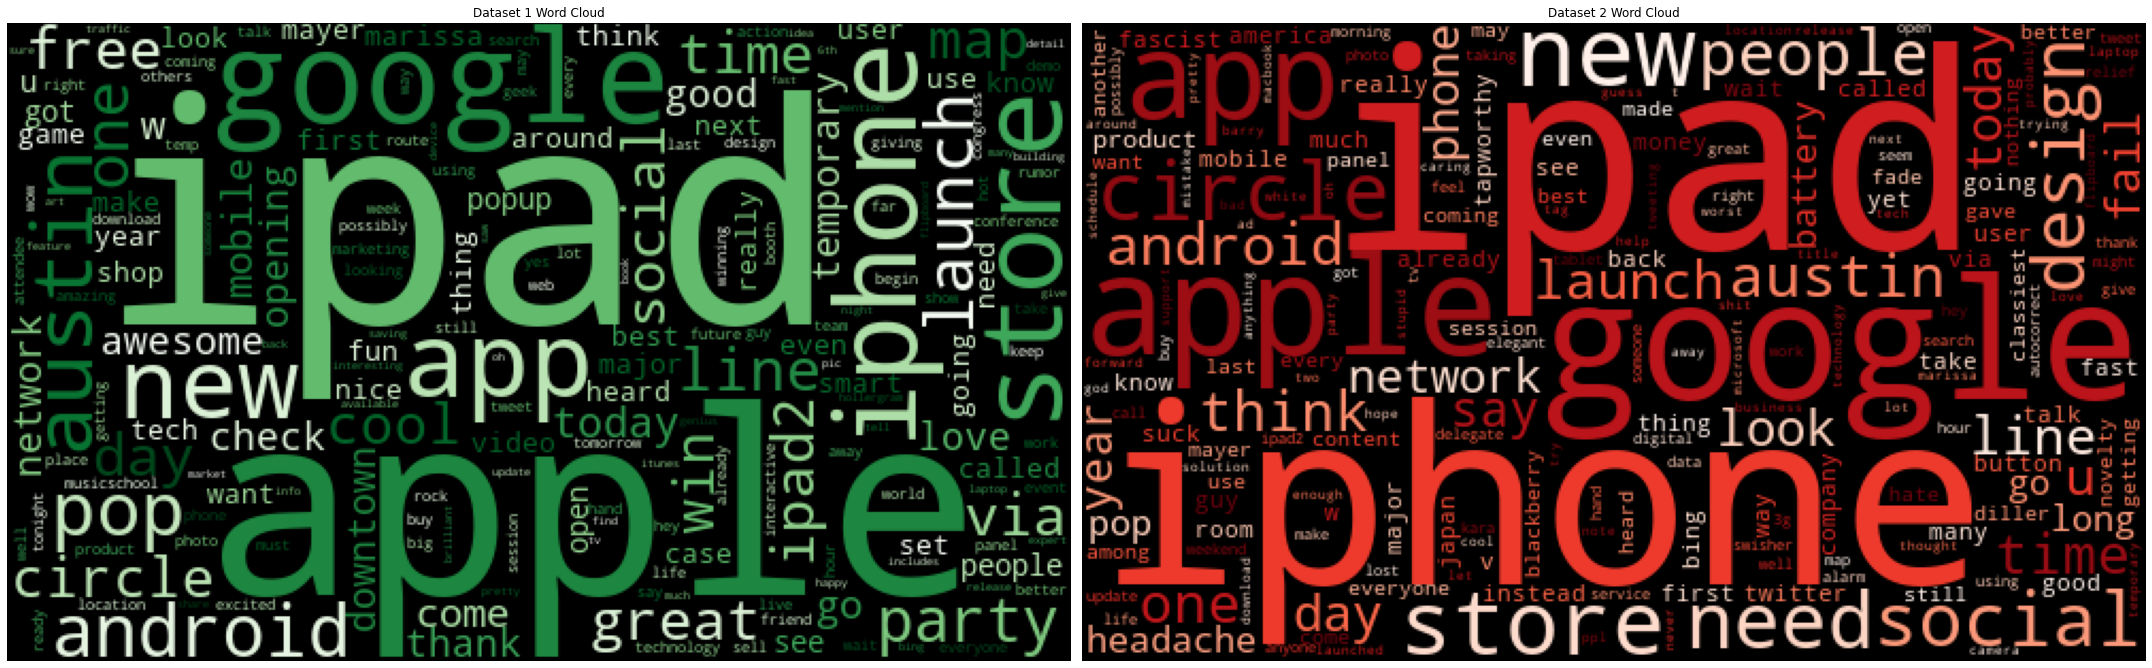

In [166]:
generate_wordcloud(tokens_pos_cleaned, tokens_neg_cleaned)

Both brands, Apple and Google as well as their products are mentioned extensively in both negative and positive tweets. Even though these wordclouds are a good starting point, it is difficult to extract any specific insights about the companies or products based on these.

## Without Product/Brand Information

We generate a word cloud without Product/Brand information just sentiments


In [167]:
# A function to help add words to stop list 
def update_stop_list(tokens, additional_stops):
    """
    Adds additional stop words to the stop list and filters tokens.
    
    Arguments:
    tokens: List of tokens to filter.
    additional_stops: List of additional stop words (e.g., brand or product names).
    
    Returns:
    Cleaned list of tokens.
    """
    # Extend stop list with additional stops
    stop_list = stopwords.words('english') + list(string.punctuation)
    stop_list += ['“', '”', '...', "''", '’', '``', ''] + additional_stops

    # Filter tokens by removing stopwords and unwanted terms
    tokens_cleaned = [token for token in tokens if token.lower() not in stop_list]
    return tokens_cleaned


In [168]:
# list of brands and products
additional_stops = ['ipad', 'apple', 'google', 'iphone', '#apple', '#google', '#ipad', '#iphone', 'android']

In [169]:
# cleaning tokens by removing additional stop words
tokens_pos_cleaned_1 = update_stop_list(tokens_pos_cleaned, additional_stops)
tokens_neg_cleaned_1 = update_stop_list(tokens_neg_cleaned,additional_stops)

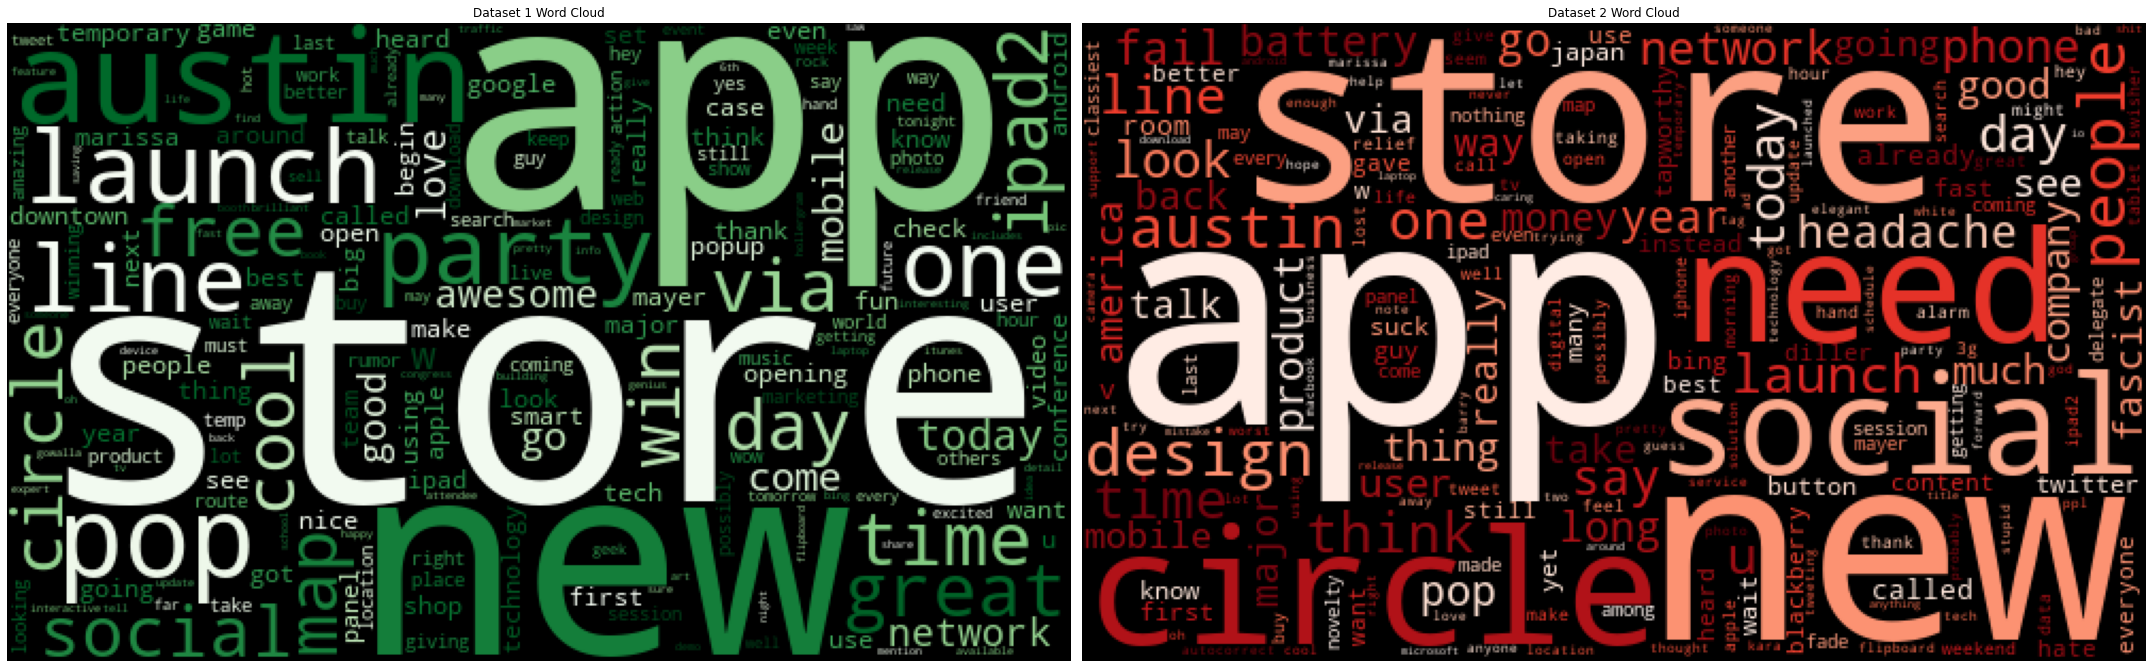

In [170]:
generate_wordcloud(tokens_pos_cleaned_1,tokens_neg_cleaned_1)

Removing company and product names from the word clouds helped reveal additional insights, though it made it harder to determine which company was linked to negative mentions. This analysis aimed to provide context about the event rather than stakeholder-specific insights. Understanding the conference led us to research certain topics, such as Apple's temporary pop-up store in downtown Austin for the iPad 2 launch, which drew large crowds. To answer our initial questions, we will conduct a more granular analysis by categorizing tweets based on sentiment and specific companies or products